## Analyzing Machine Learning Models to Accelerate Generation of Fundamental Materials Insights
### M. Umehara, H. S. Stein, D. Guevarra, P. F. Newhouse, D. A. Boyd, J. M. Gregoire

#### Calculation of R2 score for the CNN model and Kernel Ridge Regression and Random Forest Regression

In [1]:
%matplotlib inline

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from scipy import interpolate
from scipy.stats import pearsonr
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Conv1D, MaxPooling1D
from keras.layers import Concatenate, Add
from keras.optimizers import SGD, Adadelta, Adam
from keras.layers import Input
from keras.models import Model
from keras import backend as K
from keras.initializers import TruncatedNormal
from keras.utils.vis_utils import plot_model
from keras.models import load_model
from datetime import datetime
from time import gmtime, strftime
import os
import h5py
import pickle
import matplotlib.colors as mcolors
import matplotlib.cm as cm


Using TensorFlow backend.


In [2]:
# Check the GPU availability. GPU calculation is recomended.
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15735337505470232561
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 16234781501121441297
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 10634673183327946451
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10231552410
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9768150629925230733
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [3]:
# Original color map deffinition
def cmap_negpos(neglimit, poslimit, zerosensitivity=0.9, invert=False, returncdict=False, setover=False, setunder=False):
    #makes a colormap that is like jet but cuts to black at 0 so that positives and negaatives are clearly distinguished
    #invert inverts the colors so neglimit should still be negative
    #neg or pos limits can be 0. and if both have the same sign the one closest to zero will be black
    #zerosensitivity should be (0.,1.) and indicates how close to zero the values should start getting colored
    if invert:
        n=1.*poslimit
        p=1.*neglimit        
    else:
        p=1.*poslimit
        n=1.*neglimit

    xcdictneg=   {'red':   [(0., 0, 0), (0.35, 0, 0)],
                   'green': [(0., 0, 0), (0.125,0, 0), (0.375,1, 1)],
                   'blue':  [(0., 0.5, 0.5), (0.11, 1, 1), (0.34, 1, 1)]}

    xcdictpos=   {'red':   [(0.66, 1, 1), (0.89,1, 1),(1, 0.5, 0.5)],
                   'green': [(0.64,1, 1), (0.91,0,0), (1, 0, 0)],
                   'blue':  [(0.65,0, 0), (1, 0, 0)]}
                   
    cdictneg=   {'red':   [(0., 0.5, 0.5), (0.35, 0, 0)],
                   'green': [(0., 0, 0), (0.125,0, 0), (0.375,0, 0)],
                   'blue':  [(0., 1, 1), (0.11, 1, 1), (0.34, 1, 1)]}

    cdictpos=   {'red':   [(0.66, .1, .1), (0.89,.6, .6),(1, 1., 1)],
                   'green': [(0.64,.4, .4), (0.91,0.7,0.7), (1, 1., 1)],
                   'blue':  [(0.65,0, 0), (1, 0, 0)]}
                             
    cdict=dict([('red', []), ('green', []), ('blue', [])])

    z=max(min(1., -n/(p-n)), 0.)
    
    rz=1.-z
    
    
    for k in ['red', 'green', 'blue']:
        for tup in cdictneg[k]:
            if z==0:
                break
            x=tup[0]*zerosensitivity*z/0.5
            cdict[k]+=[(x, tup[1], tup[2])]
        cdict[k]+=[(z, 0, 0)]
        for tup in cdictpos[k]:
            if rz==0:
                break
            x=1.-(1.-tup[0])*zerosensitivity*rz/0.5
            cdict[k]+=[(x, tup[1], tup[2])]
        if invert:
            cdict[k]=[(1.-tup[0], tup[1], tup[2]) for tup in cdict[k]]
        cdict[k]=sorted(cdict[k])
    cmap=mcolors.LinearSegmentedColormap('NegPos', cdict)
    
    if invert:
        ovcol=(0.5, 0., 1.)
        uncol=(1., 1., 0.)
    else:
        uncol=(0.5, 0., 1.)
        ovcol=(1., 1., 0.)
    if setover:
        cmap.set_over(ovcol)
    if setunder:
        cmap.set_under(uncol)
    if returncdict:
        return cmap, cdict
    return cmap

In [4]:
# CNN model class, which input is composition and spectrum data and output is photocatalytic power generation value, overrideing sklearn.BaseEstimator and RegressorMixin
class SpectraCompositionNNRegressor(BaseEstimator, RegressorMixin):
    '''
    Fit&predict using neural network
    x : numpy array of spectra data and composition data, like numpy.c_[spectra, composition]
    y : target values
    
    n_spec_datapoint : the number of datapoint in one spectrum data, like spectra.shape[-1]
    nn_mode = 'spec_comp', 'spec', 'comp'
    n_comp_layer : the number of dens layers of composition 
    n_comp_unit : the number of units in dens layer of composition, list or int
    n_comp_epoch : the number of epoch in composition NN
    n_comp_dropout : the number of dropout rate in composition NN, list or int
    n_spec_layer : the number of CNN layers of spectra
    n_spec_filter : the filters of CNN layer of spectra, list or int
    n_spec_kernel : the kernel size of CNN layer of spectra, list or int
    n_spec_epoch : the number of epoch in spectra CNN
    n_spec_dropout : the number of dropout rate in spectra CNN, list or int
    spec_maxpool : use Max Pooling Layer (True) or not (False)
    n_merge_layer : the number of dens layers after merge
    n_merge_unit : the number of units in dens layers after merge, list or int
    n_merge_epoch : the number of epoch in merged NN
    n_merge_dropout : the number of dropout rate in merged NN, list or int
    optimizer : optimizer used, default is 'adam' (should be supported by Keras and should be str data type like 'sgd' or 'adam')
    
    Default is; nn_mode='spec_comp', n_comp_layer=2, n_comp_unit=16, n_comp_epoch=700, n_comp_dropout=0, n_spec_layer=1, n_spec_filter=2, n_spec_kernel=7, n_spec_epoch=200, n_spec_dropout=0.25, spec_maxpool=False, n_merge_layer=3, n_merge_unit=32, n_merge_epoch=400, n_merge_dropout=0, optimizer='adam'
    
    methods
    fit : fit to the data
    predict : predict using given data
    get_gradient : calculate gradient
    For the implementation of gradient calculation, see Keras blog; https://blog.keras.io/how-convolutional-neural-networks-see-the-world.html    
    '''
    def __init__(self, n_spec_datapoint,nn_mode='spec_comp', n_comp_layer=2, n_comp_unit=16, n_comp_epoch=700, n_comp_dropout=0, n_spec_layer=1, n_spec_filter=2, n_spec_kernel=7, n_spec_epoch=200, n_spec_dropout=0.25, spec_maxpool=False, n_merge_layer=3, n_merge_unit=32, n_merge_epoch=400, n_merge_dropout=0, optimizer='adam'):
        self.n_spec_datapoint=n_spec_datapoint
        self.nn_mode = nn_mode
        self.n_comp_layer = n_comp_layer
        self.n_comp_unit = n_comp_unit        
        self.n_comp_epoch = n_comp_epoch
        self.n_comp_dropout = n_comp_dropout
        self.n_spec_layer = n_spec_layer        
        self.n_spec_filter = n_spec_filter
        self.n_spec_kernel = n_spec_kernel
        self.n_spec_epoch = n_spec_epoch        
        self.n_spec_dropout = n_spec_dropout
        self.spec_maxpool = spec_maxpool
        self.n_merge_layer = n_merge_layer
        self.n_merge_unit = n_merge_unit        
        self.n_merge_epoch = n_merge_epoch
        self.n_merge_dropout = n_merge_dropout        
        self.optimizer = optimizer                

    def fit(self, x, y):
        if isinstance(self.n_comp_unit, list):
            self.n_comp_unit_ = self.n_comp_unit
        else:
            self.n_comp_unit_ = [self.n_comp_unit]*(self.n_comp_layer)
        
        if isinstance(self.n_comp_dropout, list):
            self.n_comp_dropout_ = self.n_comp_dropout
        else:
            self.n_comp_dropout_ = [self.n_comp_dropout]*(self.n_comp_layer+1)
        
        if isinstance(self.n_spec_filter, list):
            self.n_spec_filter_ = self.n_spec_filter
        else:
            self.n_spec_filter_ = [self.n_spec_filter]*(self.n_spec_layer)
        if isinstance(self.n_spec_kernel, list):
            self.n_spec_kernel_ = self.n_spec_kernel
        else:
            self.n_spec_kernel_ = [self.n_spec_kernel]*(self.n_spec_layer)

        if isinstance(self.n_spec_dropout, list):
            self.n_spec_dropout_ = self.n_spec_dropout
        else:
            self.n_spec_dropout_ = [self.n_spec_dropout]*(self.n_spec_layer+1)
        
        if isinstance(self.n_merge_unit, list):
            self.n_merge_unit_ = self.n_merge_unit
        else:
            self.n_merge_unit_ = [self.n_merge_unit]*(self.n_merge_layer)
        
        if isinstance(self.n_merge_dropout, list):
            self.n_merge_dropout_ = self.n_merge_dropout
        else:
            self.n_merge_dropout_ = [self.n_merge_dropout]*(self.n_merge_layer+1)
        
        #input_shape
        if (self.nn_mode == 'spec_comp'):
            inputshape_spec = (self.n_spec_datapoint,1)
            inputshape_comp = ((len(x[0,:])-self.n_spec_datapoint),)
        elif (self.nn_mode == 'spec'):
            inputshape_spec = (self.n_spec_datapoint,1)
        elif (self.nn_mode == 'comp'):
            inputshape_comp = ((len(x[0,:])-self.n_spec_datapoint),)
        else:
            print('nn_mode error')
        x_spec = x[:,:self.n_spec_datapoint].reshape(len(x),-1,1)
        x_comp = x[:,self.n_spec_datapoint:]
            
        if (self.nn_mode == 'spec_comp')|(self.nn_mode == 'spec'):#spec_comp
            #bottom layer
            
            model_spec = Sequential()
            if self.n_spec_dropout_[0] > 0.0:
                model_spec.add(Dropout(self.n_spec_dropout_[0], input_shape=inputshape_spec))
                model_spec.add(Conv1D(self.n_spec_filter_[0], kernel_size=self.n_spec_kernel_[0], kernel_initializer=TruncatedNormal(stddev=0.01), name='conv_1'))
            else:
                model_spec.add(Conv1D(self.n_spec_filter_[0], input_shape=inputshape_spec, kernel_size=self.n_spec_kernel_[0], kernel_initializer=TruncatedNormal(stddev=0.01), name='conv_1'))
            if self.spec_maxpool: model_spec.add(MaxPooling1D(pool_size=2))
            model_spec.add(Activation('elu'))            
            if self.n_spec_dropout_[1]>0: model_spec.add(Dropout(self.n_spec_dropout_[1]))
            #middle layer
            for n_layer in range(1,self.n_spec_layer):
                model_spec.add(Conv1D(self.n_spec_filter_[n_layer], kernel_size=self.n_spec_kernel_[n_layer], kernel_initializer=TruncatedNormal(stddev=0.01), name='conv_%d'%(n_layer+1)))
                if self.spec_maxpool: model_spec.add(MaxPooling1D(pool_size=2))
                model_spec.add(Activation('elu'))            
                if self.n_spec_dropout_[n_layer+1]>0: model_spec.add(Dropout(self.n_spec_dropout_[n_layer+1]))
            #merger layer
            model_spec.add(Flatten())
            if self.n_merge_dropout_[0] > 0.0: model_spec.add(Dropout(self.n_merge_dropout_[0]))
            for n_layer in range(self.n_merge_layer-1):
                model_spec.add(Dense(self.n_merge_unit_[n_layer], kernel_initializer=TruncatedNormal(stddev=0.01), name='merg_%d'%(n_layer+1)))
                model_spec.add(Activation('elu'))
                if self.n_merge_dropout_[n_layer+1]>0: model_spec.add(Dropout(self.n_merge_dropout_[n_layer+1]))
            #top layer
            model_spec.add(Dense(1, kernel_initializer=TruncatedNormal(stddev=0.01), name='top'))
            model_spec.add(Activation('linear'))
            model_spec.compile(loss='mean_squared_error', optimizer=self.optimizer)
            
            #model_spec = KerasRegressor(build_fn=self.model_spec_func)
            hist_spec = model_spec.fit(x_spec, y, batch_size=10, epochs=self.n_spec_epoch, verbose=0)
                
            self.hist_comp_ = hist_spec
            self.model_spec_ = model_spec
        if (self.nn_mode == 'spec_comp')|(self.nn_mode == 'comp'):#comp
            model_comp = Sequential()
            if self.n_comp_dropout_[0] > 0.0:
                model_comp.add(Dropout(self.n_comp_dropout_[0], input_shape=inputshape_comp))
                model_comp.add(Dense(self.n_comp_unit_[0], kernel_initializer=TruncatedNormal(stddev=0.01), name='dens_1'))
            else:
                model_comp.add(Dense(self.n_comp_unit_[0], input_shape=inputshape_comp, kernel_initializer=TruncatedNormal(stddev=0.01), name='dens_1'))
            model_comp.add(Activation('elu'))
            if self.n_comp_dropout_[1] > 0.0: model_comp.add(Dropout(self.n_comp_dropout_[1]))
            #middle layer
            for n_layer in range(1,self.n_comp_layer):
                model_comp.add(Dense(self.n_comp_unit_[n_layer], kernel_initializer=TruncatedNormal(stddev=0.01), name='dens_%d'%(n_layer+1)))
                model_comp.add(Activation('elu'))
                if self.n_comp_dropout_[n_layer+1]>0: model_comp.add(Dropout(self.n_comp_dropout_[n_layer+1]))
            #merger layer
            if self.n_merge_dropout_[0] > 0.0: model_comp.add(Dropout(self.n_merge_dropout_[0]))
            for n_layer in range(self.n_merge_layer-1):
                model_comp.add(Dense(self.n_merge_unit_[n_layer], kernel_initializer=TruncatedNormal(stddev=0.01), name='merg_%d'%(n_layer+1)))
                model_comp.add(Activation('elu'))
                if self.n_merge_dropout_[n_layer+1]>0: model_comp.add(Dropout(self.n_merge_dropout_[n_layer+1]))
            #top layer
            model_comp.add(Dense(1, kernel_initializer=TruncatedNormal(stddev=0.01), name='top'))
            model_comp.add(Activation('linear'))
            model_comp.compile(loss='mean_squared_error', optimizer=self.optimizer)
 
            hist_comp = model_comp.fit(x_comp, y, batch_size=10, epochs=self.n_comp_epoch, verbose=0)

            self.hist_comp_ = hist_comp
            self.model_comp_ = model_comp

        if (self.nn_mode) == 'spec_comp':
            #spec
            model_spec_2 = Sequential()
            #bottom layer
            if self.n_spec_dropout_[0] > 0.0:
                model_spec_2.add(Dropout(self.n_spec_dropout_[0], input_shape=inputshape_spec))
                model_spec_2.add(Conv1D(self.n_spec_filter_[0], kernel_size=self.n_spec_kernel_[0], kernel_initializer=TruncatedNormal(stddev=0.01), name='conv_1'))
            else:
                model_spec_2.add(Conv1D(self.n_spec_filter_[0], input_shape=inputshape_spec, kernel_size=self.n_spec_kernel_[0], kernel_initializer=TruncatedNormal(stddev=0.01), name='conv_1'))
            if self.spec_maxpool: model_spec_2.add(MaxPooling1D(pool_size=2))
            model_spec_2.add(Activation('elu'))            
            if self.n_spec_dropout_[1] > 0.0: model_spec_2.add(Dropout(self.n_spec_dropout_[1]))
            #middle layer
            for n_layer in range(1,self.n_spec_layer):
                model_spec_2.add(Conv1D(self.n_spec_filter_[n_layer], kernel_size=self.n_spec_kernel_[n_layer], kernel_initializer=TruncatedNormal(stddev=0.01), name='conv_%d'%(n_layer+1)))
                if self.spec_maxpool: model_spec_2.add(MaxPooling1D(pool_size=2))
                model_spec_2.add(Activation('elu'))            
                if self.n_spec_dropout_[n_layer+1]>0: model_spec_2.add(Dropout(self.n_spec_dropout_[n_layer+1]))
            #set weight
            for n_layer in range(self.n_spec_layer):
                model_spec_2.get_layer('conv_%d'%(n_layer+1)).set_weights(model_spec.get_layer('conv_%d'%(n_layer+1)).get_weights())
            model_spec_2.add(Flatten())
            #comp
            model_comp_2 = Sequential()
            if self.n_comp_dropout_[0] > 0.0:
                model_comp_2.add(Dropout(self.n_comp_dropout_[0], input_shape=inputshape_comp))
                model_comp_2.add(Dense(self.n_comp_unit_[0], kernel_initializer=TruncatedNormal(stddev=0.01), name='dens_1'))
            else:
                model_comp_2.add(Dense(self.n_comp_unit_[0], input_shape=inputshape_comp, kernel_initializer=TruncatedNormal(stddev=0.01), name='dens_1'))
            model_comp_2.add(Activation('elu'))            
            if self.n_comp_dropout_[1] > 0.0: model_comp_2.add(Dropout(self.n_comp_dropout_[1]))
            #middle layer
            for n_layer in range(1,self.n_comp_layer):
                model_comp_2.add(Dense(self.n_comp_unit_[n_layer], kernel_initializer=TruncatedNormal(stddev=0.01), name='dens_%d'%(n_layer+1)))
                model_comp_2.add(Activation('elu'))            
                if self.n_comp_dropout_[n_layer+1] > 0.0: model_comp_2.add(Dropout(self.n_comp_dropout_[n_layer+1]))
            #set weight
            for n_layer in range(self.n_comp_layer):
                model_comp_2.get_layer('dens_%d'%(n_layer+1)).set_weights(model_comp.get_layer('dens_%d'%(n_layer+1)).get_weights())
            #merge
            input_spec = model_spec_2.input
            input_comp = model_comp_2.input
            
            merged_out = Concatenate()([model_spec_2.output, model_comp_2.output])
            if self.n_merge_dropout_[0] > 0.0: merged_out = Dropout(self.n_merge_dropout_[0])(merged_out)
            for n_layer in range(self.n_merge_layer-1):
                dense_out = Dense(self.n_merge_unit_[n_layer], kernel_initializer=TruncatedNormal(stddev=0.01), name='merge_%d'%(n_layer+1))(merged_out)
                merged_out = Activation('elu')(dense_out)
                if self.n_merge_dropout_[n_layer+1] > 0.0: merged_out = Dropout(self.n_merge_dropout_[n_layer+1])(merged_out)
            #top layer
            dense_out = Dense(1, kernel_initializer=TruncatedNormal(stddev=0.01), name='top')(merged_out)
            final_out = Activation('linear')(dense_out)
            model_merge = Model(inputs=[input_spec, input_comp], outputs=final_out)
            
            model_merge.compile(loss='mean_squared_error', optimizer=self.optimizer)

            hist_merge = model_merge.fit([x_spec,x_comp], y, batch_size=10, epochs=self.n_merge_epoch, verbose=0)

            self.hist_merge_ = hist_merge
            self.model_merge_ = model_merge
        return self
    
    def predict(self, x):
        x_spec = x[:,:self.n_spec_datapoint].reshape(len(x),-1,1)
        x_comp = x[:,self.n_spec_datapoint:]
        if self.nn_mode == 'spec': 
            self.predicted_val = self.model_spec_.predict(x_spec)
            return self.model_spec_.predict(x_spec)        
        if self.nn_mode == 'comp': 
            self.predicted_val = self.model_comp_.predict(x_comp)
            return self.model_comp_.predict(x_comp)        
        if self.nn_mode == 'spec_comp': 
            self.predicted_val = self.model_merge_.predict([x_spec,x_comp])
            return self.model_merge_.predict([x_spec,x_comp])
    def get_gradient(self, x):
        if (self.nn_mode == 'spec_comp'): 
            x_spec = x[:,:self.n_spec_datapoint].reshape(len(x),-1,1)
            x_comp = x[:,self.n_spec_datapoint:]
            #
            input_spec = self.model_merge_.input[0]
            input_comp = self.model_merge_.input[1]
            grads_spec_ = K.gradients(self.model_merge_.layers[-1].output, [input_spec, input_comp])[0]
            grads_spec = grads_spec_/(K.sqrt(K.mean(K.square(grads_spec_))) + K.epsilon())
            grads_comp_ = K.gradients(self.model_merge_.layers[-1].output, [input_spec, input_comp])[1]
            grads_comp = grads_comp_/(K.sqrt(K.mean(K.square(grads_comp_))) + K.epsilon())
            iterate_spec = K.function([input_spec, input_comp, K.learning_phase()], [self.model_merge_.layers[-1].output, grads_spec,grads_spec_])
            iterate_comp = K.function([input_spec, input_comp, K.learning_phase()], [self.model_merge_.layers[-1].output, grads_comp,grads_comp_])
            grads_spec_out=[]
            grads_comp_out=[]
            grads_spec_out_=[]
            grads_comp_out_=[]
            for i in range(len(x)):
                spec=np.copy(x_spec[i:i+1])
                comp=np.copy(x_comp[i:i+1])
                activation_value1, grads_value1,grads_value1_ = iterate_spec([spec,comp,0])
                activation_value2, grads_value2,grads_value2_ = iterate_comp([spec,comp,0])
                grads_spec_out.append(grads_value1.reshape(-1))
                grads_comp_out.append(grads_value2.reshape(-1))
                grads_spec_out_.append(grads_value1_.reshape(-1))
                grads_comp_out_.append(grads_value2_.reshape(-1))
            grads_spec_out=np.array(grads_spec_out)
            grads_comp_out=np.array(grads_comp_out)
            grads_spec_out=np.array(grads_spec_out_)
            grads_comp_out=np.array(grads_comp_out_)
            #
            return [grads_spec_out, grads_comp_out,grads_spec_out_, grads_comp_out_]
        elif (self.nn_mode == 'spec'): 
            x_spec = x[:,:self.n_spec_datapoint].reshape(len(x),-1,1)
            #
            input_spec = self.model_spec_.input
            grads_spec = K.gradients(self.model_spec_.layers[-1].output, [input_spec])[0]
            grads_spec /= (K.sqrt(K.mean(K.square(grads_spec))) + K.epsilon())
            iterate_spec = K.function([input_spec, K.learning_phase()], [self.model_spec_.layers[-1].output, grads_spec])
            grads_spec_out=[]
            for i in range(len(x)):
                spec=np.copy(x_spec[i:i+1])
                activation_value1, grads_value1 = iterate_spec([spec,0])
                grads_spec_out.append(grads_value1.reshape(-1))
            grads_spec_out=np.array(grads_spec_out)
            #
            return grads_spec_out
        if (self.nn_mode == 'comp'): 
            x_comp = x[:,self.n_spec_datapoint:]
            #
            input_comp = self.model_comp_.input
            grads_comp = K.gradients(self.model_comp_.layers[-1].output, [input_comp])[0]
            grads_comp /= (K.sqrt(K.mean(K.square(grads_comp))) + K.epsilon())
            iterate_comp = K.function([input_comp, K.learning_phase()], [self.model_comp_.layers[-1].output, grads_comp])
            grads_comp_out=[]
            for i in range(len(x)):
                comp=np.copy(x_comp[i:i+1])
                activation_value2, grads_value2 = iterate_comp([comp,0])
                grads_comp_out.append(grads_value2.reshape(-1))
            grads_comp_out=np.array(grads_comp_out)
            #
            return grads_comp_out


In [5]:
# data folder
datafoldername = r'.' #somewhere
resultsavefolder=os.path.join(datafoldername, 'result_%s' %strftime("%Y%m%d.%H%M%S", gmtime()))
os.mkdir(resultsavefolder)

df_dataset = pd.read_csv(os.path.join(datafoldername,'dataset.csv'),skiprows=1)

In [6]:
print (df_dataset)

      Sample        Bi         V         W   Dy   Gd   Mo        Tb    78.025  \
0         97  0.516214  0.476506  0.007280  0.0  0.0  0.0  0.000000  0.089489   
1         98  0.512484  0.473062  0.014455  0.0  0.0  0.0  0.000000  0.088502   
2         99  0.508806  0.469667  0.021526  0.0  0.0  0.0  0.000000  0.078689   
3        100  0.505181  0.466321  0.028497  0.0  0.0  0.0  0.000000  0.080347   
4        101  0.501608  0.463023  0.035370  0.0  0.0  0.0  0.000000  0.083081   
5        102  0.498084  0.459770  0.042146  0.0  0.0  0.0  0.000000  0.087127   
6        103  0.491941  0.454100  0.053959  0.0  0.0  0.0  0.000000  0.085956   
7        104  0.488178  0.450626  0.061196  0.0  0.0  0.0  0.000000  0.084378   
8        105  0.484472  0.447205  0.068323  0.0  0.0  0.0  0.000000  0.086173   
9        106  0.480822  0.443836  0.075342  0.0  0.0  0.0  0.000000  0.085230   
10       107  0.498084  0.494891  0.007024  0.0  0.0  0.0  0.000000  0.093003   
11       108  0.494610  0.49

In [7]:
sample_no = df_dataset['Sample'].values
elements = np.array(df_dataset.keys().values[1:8], dtype='2U')
wavenumbers = np.array(df_dataset.keys().values[8:-1], dtype='float64')
P = df_dataset['P'].values
compositions = df_dataset.values[:,1:8]
spectra = df_dataset.values[:,8:-1]


In [8]:
sample_no.dtype

dtype('int64')

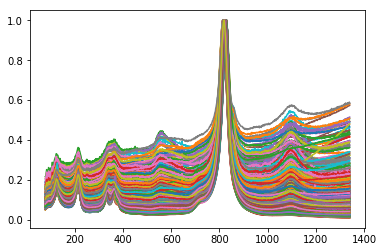

In [9]:
plt.figure()
[plt.plot(wavenumbers,spec) for spec in spectra]
plt.show()

In [10]:
# Standarization of P
area = 0.86*0.1*0.86*0.1*np.pi/2./2. #spot size of the effective photo-electrode
P = P/1e3*area #P (mw/cm2) -> P (W)


In [11]:
sc = StandardScaler()
P_ss = sc.fit_transform(P.reshape(-1,1)).reshape(-1)
P_mean = sc.mean_
P_std = np.sqrt(sc.var_)
P_W = P
P_mW = P_W*1e3
area = 0.86*0.1*0.86*0.1*np.pi/2./2.
P_mW_cm2 = P_mW/area

grad_comp_coef = P_std * 1e3 / area / 100
grad_spec_coef = P_std * 1e3 / area
P_coef = 1e3 / area

print('max P_ss: %f'%P_ss.max())
print('min P_ss: %f'%P_ss.min())

max P_ss: 4.164928
min P_ss: -1.322271


In [12]:
# Normalize spectra at main peak
spectra_n = np.array([itm/np.max(itm[(wavenumbers<850)&(wavenumbers>750)]) for itm in spectra])

print('max spectra_n: %f'%spectra_n.max())
print('min spectra_n: %f'%spectra_n.min())


max spectra_n: 1.000000
min spectra_n: 0.010064


In [13]:
estimators=['cnn_1']#,'rfr','kr']

In [14]:
n_cv=1 #number of cross validation
n_repeat=150 #number of repeat 

print('cnn_1')
cnn_1=SpectraCompositionNNRegressor(n_spec_datapoint=spectra_n.shape[-1])
params_cnn_1={'n_comp_epoch':[700]}
cnn_1_gs=GridSearchCV(cnn_1, param_grid=params_cnn_1, cv=n_cv, scoring='r2', return_train_score=True, refit=True)

print('rfr')
params_rfr = {'max_depth':[30,100,300], 'n_estimators':[30,100,200], 'max_features':['auto'], 'min_samples_split':[2], 'min_samples_leaf':[1]}
rfr = RandomForestRegressor()
rfr_gs = GridSearchCV(rfr, param_grid=params_rfr, cv=n_cv, scoring='r2', return_train_score=True, refit=True)

print('kr')
params_kr = {'alpha':[1e-4,1e-3,1e-2,1e-1], 'kernel':['rbf'],'gamma':[1e-3,1e-1,1e1]}
kr = KernelRidge()
kr_gs = GridSearchCV(kr, param_grid=params_kr, cv=n_cv, scoring='r2', return_train_score=True, refit=True)

cnn_1
rfr
kr


In [15]:
#Dataset shuffle
use_shuffle_index_file = False

shuffle_index=[]

if use_shuffle_index_file:
    shuffle_index = np.loadtxt(os.path.join(datafoldername,'shuffle_index.txt'),dtype=np.int32)
else:
    for rep in range(n_repeat):
        # split train and test
        indices = np.random.RandomState().permutation(range(len(spectra)),)
        shuffle_index.append(indices)
    shuffle_index=np.array(shuffle_index, dtype='int32')
    np.savetxt(os.path.join(resultsavefolder, 'shuffle_index.txt'),shuffle_index)

In [16]:
result={}
model={}
for estimator in estimators:
    exec('result["'+estimator+'"]={}')
    exec('model["'+estimator+'"]={}')
    exec('result["'+estimator+'"]["cv_results_"]=[]')                
    exec('result["'+estimator+'"]["refit_score"]=[]')
    exec('model["'+estimator+'"]["refit_model"]=[]')

In [ ]:
#Train 
for rep in range(n_repeat):
    print('run %d'%rep)
    indices = shuffle_index[rep]
    X_spec = spectra_n[indices]
    X_comp = compositions[indices]
    Y = P_ss[indices]
    X = np.c_[X_spec,X_comp]
    
    for estimator in estimators:
        
        #reg = eval(estimator+'_gs')
        #print('%s model training started at: %s' %(estimator, datetime.now().strftime("%Y/%m/%d_%H:%M:%S")))
        #reg.fit(X,Y)
        #print('%s model training finished at: %s' %(estimator, datetime.now().strftime("%Y/%m/%d_%H:%M:%S")))
        #print(datetime.now().strftime("%Y/%m/%d_%H:%M:%S"))
        #Y_predicted_temp = reg.predict(np.c_[spectra_n,compositions])
        #score_temp = r2_score(P_ss,Y_predicted_temp.reshape(-1))
        #np.savetxt(os.path.join(resultsavefolder, estimator+'_Y_predicted_%d.txt' %rep), Y_predicted_temp)
        #exec('result["'+estimator+'"]["cv_results_"].append(reg.cv_results_)')
        #exec('result["'+estimator+'"]["refit_score"].append(score_temp)')
        #exec('model["'+estimator+'"]["refit_model"].append(reg.best_estimator_)')
        cnn_1=SpectraCompositionNNRegressor(n_spec_datapoint=spectra_n.shape[-1])
        reg = eval(estimator)
        print('%s model training started at: %s' %(estimator, datetime.now().strftime("%Y/%m/%d_%H:%M:%S")))
        reg.fit(X,Y)
        print('%s model training finished at: %s' %(estimator, datetime.now().strftime("%Y/%m/%d_%H:%M:%S")))
        print(datetime.now().strftime("%Y/%m/%d_%H:%M:%S"))
        Y_predicted_temp = reg.predict(np.c_[spectra_n,compositions])
        score_temp = r2_score(P_ss,Y_predicted_temp.reshape(-1))
        np.savetxt(os.path.join(resultsavefolder, estimator+'_Y_predicted_%d.txt' %rep), Y_predicted_temp)
        #exec('result["'+estimator+'"]["cv_results_"].append(reg.cv_results_)')
        exec('result["'+estimator+'"]["refit_score"].append(score_temp)')
        exec('model["'+estimator+'"]["refit_model"].append(reg)')

        
        #print(estimator+' %d'%rep+' best_params: ')
        #print(reg.best_params_)
        #print(estimator+' %d'%rep+' best_score: %f'%reg.best_score_)


run 0
cnn_1 model training started at: 2019/01/19_11:53:35
cnn_1 model training finished at: 2019/01/19_12:03:40
2019/01/19_12:03:40
run 1
cnn_1 model training started at: 2019/01/19_12:03:40
cnn_1 model training finished at: 2019/01/19_12:13:14
2019/01/19_12:13:14
run 2
cnn_1 model training started at: 2019/01/19_12:13:14
cnn_1 model training finished at: 2019/01/19_12:24:45
2019/01/19_12:24:45
run 3
cnn_1 model training started at: 2019/01/19_12:24:45
cnn_1 model training finished at: 2019/01/19_12:36:05
2019/01/19_12:36:05
run 4
cnn_1 model training started at: 2019/01/19_12:36:05
cnn_1 model training finished at: 2019/01/19_12:47:30
2019/01/19_12:47:30
run 5
cnn_1 model training started at: 2019/01/19_12:47:30
cnn_1 model training finished at: 2019/01/19_12:59:03
2019/01/19_12:59:03
run 6
cnn_1 model training started at: 2019/01/19_12:59:04
cnn_1 model training finished at: 2019/01/19_13:12:08
2019/01/19_13:12:08
run 7
cnn_1 model training started at: 2019/01/19_13:12:08
cnn_1 mode

In [19]:
# Save result
import json
class NumPyArangeEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist() # or map(int, obj)
        return json.JSONEncoder.default(self, obj)
a = open(os.path.join(resultsavefolder, 'result.json') , 'w')
json.dump(result,a, cls=NumPyArangeEncoder, indent=4, sort_keys=True)
a.close()

In [20]:
# Save model
for rep in range(n_repeat):
    for estimator in estimators:
        mdl = model[estimator]['refit_model'][rep]
        if estimator == 'cnn_1':
            mdl.model_comp_.save(os.path.join(resultsavefolder, 'model_comp_'+estimator+'_%d.h5' %rep))
            mdl.model_spec_.save(os.path.join(resultsavefolder, 'model_spec_'+estimator+'_%d.h5' %rep))
            mdl.model_merge_.save(os.path.join(resultsavefolder, 'model_merge_'+estimator+'_%d.h5' %rep))
        else:
            f = open(os.path.join(resultsavefolder, 'model_'+estimator+'_%d.pck' %rep), 'wb')
            pickle.dump(mdl,f)
            f.close()


In [ ]:
# Calculation of gradient (cnn)
if 'cnn_1' in estimators:
    grads_spec_all=[]
    grads_comp_all=[]
    for rep in range(n_repeat):
        print('cnn gradient calculation run %d'%rep)
        estimator = 'cnn_1'
        print(datetime.now().strftime("%Y/%m/%d_%H:%M:%S"))
        mdl = model[estimator]['refit_model'][rep]

        grads_spec, grads_comp, grads_spec_raw, grads_comp_raw = mdl.get_gradient(np.c_[spectra_n,compositions])

        #Save
        np.savetxt(os.path.join(resultsavefolder, estimator+'_spectrum_gradient_%d.txt' %rep), grads_spec) #normalized gradient
        np.savetxt(os.path.join(resultsavefolder, estimator+'_composition_gradient_%d.txt' %rep), grads_comp) #normalized gradient
        np.savetxt(os.path.join(resultsavefolder, estimator+'_spectrum_gradient_raw_%d.txt' %rep), grads_spec_raw*grad_spec_coef) #raw gradient, which is used for gradient analysis
        np.savetxt(os.path.join(resultsavefolder, estimator+'_composition_gradient_raw_%d.txt' %rep), grads_comp_raw*grad_comp_coef) #raw gradient, which is used for gradient analysis
        #
        grads_spec_all.append(grads_spec_raw*grad_spec_coef)
        grads_comp_all.append(grads_comp_raw*grad_comp_coef)
    grads_spec_all = np.array(grads_spec_all)
    grads_comp_all = np.array(grads_comp_all)
    
    # Average and std of gradient
    grads_spec_all_ave=np.average(grads_spec_all, axis=0)
    grads_comp_all_ave=np.average(grads_comp_all, axis=0)
    grads_spec_all_std=np.std(grads_spec_all, axis=0)
    grads_comp_all_std=np.std(grads_comp_all, axis=0)
    # Save
    np.savetxt(os.path.join(resultsavefolder, estimator+'_spectrum_gradient_ave.txt'), grads_spec_all_ave)
    np.savetxt(os.path.join(resultsavefolder, estimator+'_composition_gradient_ave.txt'), grads_comp_all_ave)
    np.savetxt(os.path.join(resultsavefolder, estimator+'_spectrum_gradient_std.txt'), grads_spec_all_std)
    np.savetxt(os.path.join(resultsavefolder, estimator+'_composition_gradient_std.txt'), grads_comp_all_std)
    
        

cnn gradient calculation run 0
2019/01/22_15:13:05
cnn gradient calculation run 1
2019/01/22_15:14:20
cnn gradient calculation run 2
2019/01/22_15:15:36
cnn gradient calculation run 3
2019/01/22_15:16:47
cnn gradient calculation run 4
2019/01/22_15:17:59
cnn gradient calculation run 5
2019/01/22_15:19:08
cnn gradient calculation run 6
2019/01/22_15:20:21
cnn gradient calculation run 7
2019/01/22_15:21:31
cnn gradient calculation run 8
2019/01/22_15:22:43
cnn gradient calculation run 9
2019/01/22_15:23:53
cnn gradient calculation run 10
2019/01/22_15:25:07
cnn gradient calculation run 11
2019/01/22_15:26:18
cnn gradient calculation run 12
2019/01/22_15:27:33
cnn gradient calculation run 13
2019/01/22_15:28:45
cnn gradient calculation run 14
2019/01/22_15:29:59
cnn gradient calculation run 15
2019/01/22_15:31:12
cnn gradient calculation run 16
2019/01/22_15:32:26
cnn gradient calculation run 17
2019/01/22_15:33:40
cnn gradient calculation run 18
2019/01/22_15:34:55
cnn gradient calculati

In [ ]:
# Calculation of feature importance (rfr)
if 'rfr' in estimators:
    feature_importance_spec_all=[]
    feature_importance_comp_all=[]
    for rep in range(n_repeat):
        print('feature importance calculation run %d'%rep)
        estimator = 'rfr'
        print(datetime.now().strftime("%Y/%m/%d_%H:%M:%S"))
        mdl = model[estimator]['refit_model'][rep]

        feature_importance_spec = mdl.feature_importances_[:len(wavenumbers)]
        feature_importance_comp = mdl.feature_importances_[len(wavenumbers):]
        # Save
        np.savetxt(os.path.join(resultsavefolder, estimator+'_spectrum_feature_importance_%d_.txt' %rep), mdl.feature_importances_[:len(wavenumbers)])
        np.savetxt(os.path.join(resultsavefolder, estimator+'_composition_feature_importance_%d_.txt' %rep), mdl.feature_importances_[len(wavenumbers):])
        #
        feature_importance_spec_all.append(feature_importance_spec)
        feature_importance_comp_all.append(feature_importance_comp)
    feature_importance_spec_all = np.array(feature_importance_spec_all)
    feature_importance_comp_all = np.array(feature_importance_comp_all)


In [ ]:
# Calculation of Pearson correlation coefficient
if 'cnn_1' in estimators:
    estimator = 'cnn_1'
    from scipy.stats import pearsonr
    #averaged Pearson coef matrix
    pearson_coef_mat_all=[]
    p_val_mat_all=[]
    for rep in range(n_repeat):
        grads_spec=grads_spec_all[rep]
        grads_comp=grads_comp_all[rep]
        grads_spec_comp=np.c_[grads_comp,grads_spec]
        pearson_coef_mat_ = np.zeros((len(grads_spec_comp.T),len(grads_spec_comp.T)))
        p_val_mat_ = np.zeros((len(grads_spec_comp.T),len(grads_spec_comp.T)))
        for i in range(len(grads_spec_comp.T)):
            for j in range(len(grads_spec_comp.T)):
                pearson_coef, p_val = pearsonr(grads_spec_comp.T[i],grads_spec_comp.T[j])
                pearson_coef_mat_[i,j] = pearson_coef
                p_val_mat_[i,j] = p_val
        pearson_coef_mat_ = np.array(pearson_coef_mat_)
        p_val_mat_ = np.array(p_val_mat_)
        pearson_coef_mat_all.append(pearson_coef_mat_)
        p_val_mat_all.append(p_val_mat_)
        # Save
        np.savetxt(os.path.join(resultsavefolder, estimator+'_Pearson_coef_mat_%d_.txt' %rep), pearson_coef_mat_)
        np.savetxt(os.path.join(resultsavefolder, estimator+'_Pearson_coef_p_val_mat_%d_.txt' %rep), p_val_mat_)

    pearson_coef_mat_all = np.array(pearson_coef_mat_all)
    p_val_mat_all = np.array(p_val_mat_all)

    pearson_coef_mat_all_ave=np.average(pearson_coef_mat_all,axis=0)
    p_val_mat_all_ave=np.average(p_val_mat_all,axis=0)

    np.savetxt(os.path.join(resultsavefolder, 'Ave_Pearson_coef_mat.txt'), pearson_coef_mat_all_ave)
    np.savetxt(os.path.join(resultsavefolder, 'Ave_Pearson_coef_p_val_mat.txt'), p_val_mat_all_ave)



Sample no:2065


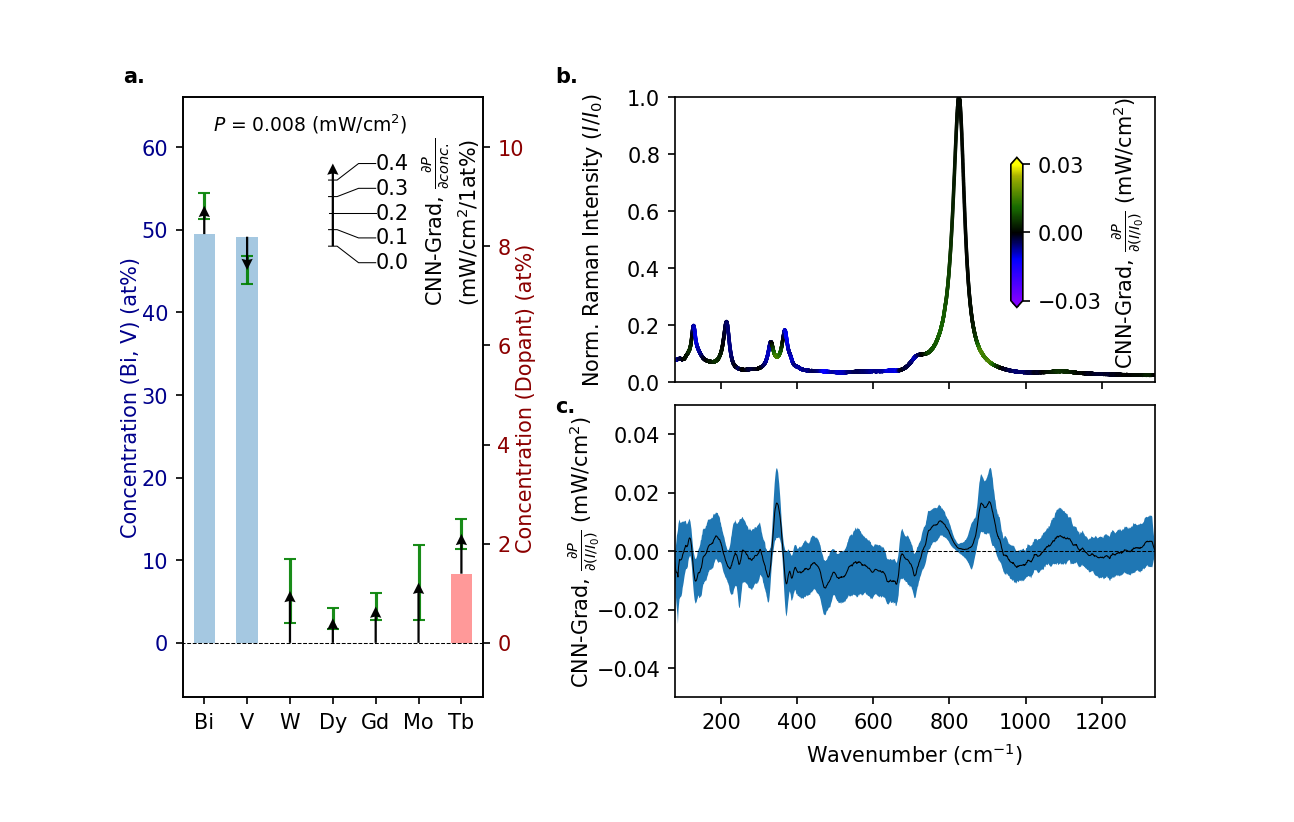

In [32]:
# Plot #2065 sample
for sn in [2065]:
    #Figure 4
    scale = 30
    sample_no_temp = sn
    ind = np.where(sample_no == sample_no_temp)[0][0]
    fig = plt.figure(figsize=(8,5), dpi=150)
    ax1 = fig.add_axes([0.1,0.1,0.25,0.8])
    ax2 = ax1.twinx()
    ax2.bar(range(len(elements))[2:],compositions[ind][2:],width=0.5,alpha=0.4, zorder=0.1, color='r',align='center')
    ax2.errorbar(range(len(elements))[2:],compositions[ind][2:]+grads_comp_all_ave[ind][2:]/scale,yerr=grads_comp_all_std[ind][2:]/scale, capsize=3, fmt='none', ecolor = 'g', alpha= 0.9, zorder=0.2)
    ax2.quiver(range(len(elements))[2:],compositions[ind][2:],[0]*(len(elements)-2),grads_comp_all_ave[ind][2:], scale=scale, scale_units='xy', headwidth=5, alpha=0.99, zorder=2.0)
    ax2.set_ylim(-0.011,0.11)
    ax2.tick_params(axis='y',labelcolor='darkred')
    ax2.set_yticks([0.0,0.02,0.04,0.06,0.08,0.1])
    ax2.set_yticklabels(['0','2','4','6','8','10'])
    ax1.bar(range(len(elements))[:2],compositions[ind][:2],width=0.5,alpha=0.4, zorder=0.1, align='center')
    ax1.errorbar(range(len(elements))[:2],compositions[ind][:2]+grads_comp_all_ave[ind][:2]/scale*6,yerr=grads_comp_all_std[ind][:2]/scale*6, capsize=3, fmt='none', ecolor = 'g', alpha= 0.9, zorder=0.2)
    ax1.quiver(range(len(elements))[:2],compositions[ind][:2],[0]*(2),grads_comp_all_ave[ind][:2], scale=scale/6, scale_units='xy', headwidth=5, alpha=0.99, zorder=2.0)
    ax1.set_ylim(-0.066,0.66)
    ax1.tick_params(axis='y',labelcolor='darkblue')
    ax1.set_yticks([0.0,0.1,0.2,0.3,0.4,0.5,0.6])
    ax1.set_yticklabels(['0','10','20','30','40','50','60'])
    ax1.plot([-10,10],[0,0],lw=0.5,linestyle='--', color='k')
    ax1.set_ylabel('Concentration (Bi, V) (at%)', color='darkblue',labelpad=0.1)
    ax2.set_ylabel('Concentration (Dopant) (at%)', color='darkred',labelpad=-0.1)
    ax2.yaxis.set_label_coords(1.11,0.5)
    plt.gca().set_xticks(range(len(elements)))
    plt.gca().set_xticklabels(elements)
    plt.xlim(-0.5,len(elements)-0.5)
    ax1.text(0.2,0.62,'$P$ = %.3f (mW/cm$^2$)'%P_mW_cm2[ind], fontsize=9)
    print('Sample no:%d'%sample_no[ind])
    arrow_x = 3.0
    arrow_y = 0.08
    arrow_ticks = np.array([0,0.1,0.2,0.3,0.4])
    arrow_length = 0.5
    ax2.quiver(arrow_x,arrow_y,0,arrow_length, scale=scale, scale_units='xy', headwidth=5, alpha=1.0)
    for i in range(len(arrow_ticks)):
        text_step = 1.5
        ticks_center = (arrow_ticks.max()-arrow_ticks.min())/2
        ax2.plot([arrow_x-0.1,arrow_x+0.1,arrow_x+0.6,arrow_x+1.0],[arrow_ticks[i]/scale+arrow_y,arrow_ticks[i]/scale+arrow_y,arrow_y+ticks_center/scale+(arrow_ticks[i]-ticks_center)*text_step/scale,arrow_y+ticks_center/scale+(arrow_ticks[i]-ticks_center)*text_step/scale], color='k', lw=0.5)
        ax2.text(arrow_x+1.0,arrow_y+ticks_center/scale+(arrow_ticks[i]-ticks_center)*text_step/scale,'%1.1f'%arrow_ticks[i], va='center')
    ax2.text(5.7,0.085,'CNN-Grad, '+r'$\frac{\partial P}{\partial conc.}$'+'\n(mW/cm$^2$/1at%)',rotation=90, va='center', ha='center')
    #
    ax4 = fig.add_axes([0.51,0.52,0.4,0.38])
    ax4.tick_params(labelbottom=False)
    n=-0.03
    p=0.03
    color=grads_spec_all_ave[ind]
    plt.xlim(wavenumbers.min(),wavenumbers.max())
    plt.ylim(0,spectra_n.max())
    wavenumbers_interp=np.linspace(wavenumbers.min(),wavenumbers.max(),10000)
    spectra_interp = interpolate.interp1d(wavenumbers, spectra_n[ind])(wavenumbers_interp)    
    color_interp = interpolate.interp1d(wavenumbers, color)(wavenumbers_interp)    
    rvb, cdict = cmap_negpos(n, p, returncdict=True, invert=False, setover=True, setunder=True)
    cbar=plt.scatter(wavenumbers_interp, spectra_interp, s=3, c=color_interp, cmap=rvb, vmin=n, vmax=p, edgecolor='none')
    ax4.yaxis.set_label_coords(-0.17,0.5)
    ax4.set_ylabel('Norm. Raman Intensity ($I/I_0$)', ha='center', va='center')
    cbar_ax = fig.add_axes([0.79, 0.62, 0.01, 0.2])
    fig.colorbar(cbar,cax=cbar_ax,extend='both',ticks=[-0.03,-0.15,0,0.15,0.03],label='CNN-Grad, '+r'$\frac{\partial P}{\partial (I/I_0)}$'+' (mW/cm$^2$)')
    #
    ax3 = fig.add_axes([0.51,0.1,0.4,0.39])
    plt.xlim(wavenumbers.min(),wavenumbers.max())
    plt.ylim(-0.05,0.05)
    ax3.fill(np.r_[wavenumbers,wavenumbers[::-1]],np.r_[grads_spec_all_ave[ind]+grads_spec_all_std[ind],(grads_spec_all_ave[ind]-grads_spec_all_std[ind])[::-1]],ec='none')#,alpha=0.5)
    #
    ax3.plot(wavenumbers,grads_spec_all_ave[ind],color='k',lw=0.5)
    #
    ax3.plot([0,2000],[0,0],lw=0.5,linestyle='--', color='k')
    ax3.yaxis.set_label_coords(-0.19,0.5)
    ax3.set_ylabel('CNN-Grad, '+r'$\frac{\partial P}{\partial (I/I_0)}$'+' (mW/cm$^2$)', ha='center', va='center')
    plt.xlabel('Wavenumber (cm$^{-1}$)')
    ax5 = fig.add_axes([0,0,1,1])
    ax5.axis('off')
    ax5.text(0.05,0.92,'a.',weight='bold')
    ax5.text(0.41,0.92,'b.',weight='bold')
    ax5.text(0.41,0.48,'c.',weight='bold')
    plt.savefig(os.path.join(resultsavefolder, 'Gradient_spec_comp_sample_%d.png'%sample_no[ind]))
    plt.savefig(os.path.join(resultsavefolder, 'Gradient_spec_comp_sample_%d.eps'%sample_no[ind]))

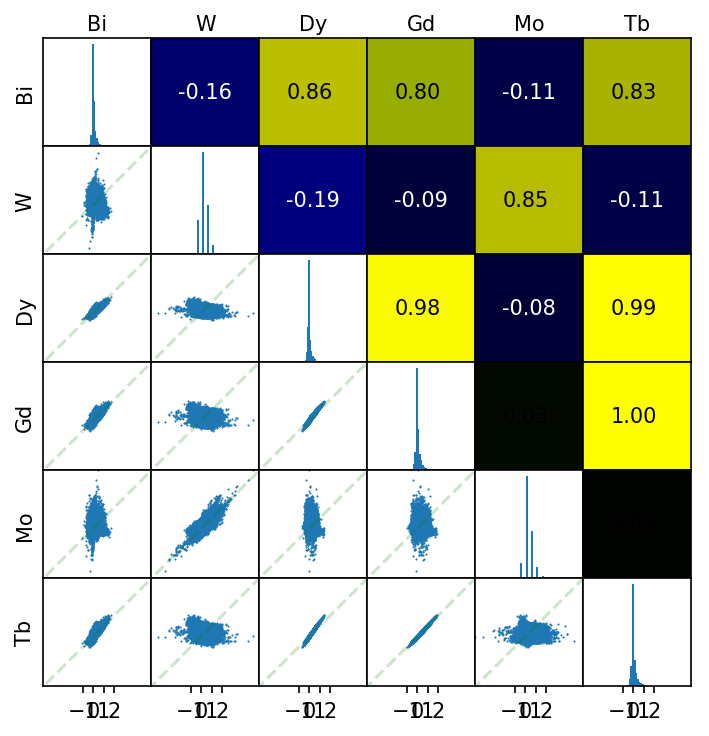

In [33]:
# Plot correlation
df_grads = pd.DataFrame(np.c_[sample_no.reshape(-1,1),grads_comp_all_ave,grads_spec_all_ave[:,::-1]],columns=['Sample']+list(elements)+['%.3f'%itm for itm in wavenumbers[::-1]])
df_grads.to_csv(os.path.join(resultsavefolder, 'grads_comp_spec.csv'))

df_pearson_coef_mat = pd.DataFrame(pearson_coef_mat_all_ave,columns=list(elements)+['%.3f'%itm for itm in wavenumbers[::-1]])
df_pearson_coef_mat.to_csv(os.path.join(resultsavefolder, 'averaged_pearson_coef_mat_comp_spec.csv'))

fig=plt.figure(figsize=(6,6), dpi=150)
ticks=elements[[0,2,3,4,5,6]]
color=pearson_coef_mat_all_ave[:,[0,2,3,4,5,6]]
color=color[[0,2,3,4,5,6],:]
grads=grads_comp_all[:,:,[0,2,3,4,5,6]]
#plt.subplots_adjust(wspace=0, hspace=0)
d_step=0.12
d_space=0.015
for i in range(6):
    for j in range(6):
        #plt.subplot(6,6,i*6+j+1)
        fig.add_axes([0.1+j*d_step,0.1+(5-i)*d_step,d_step,d_step])
        plt.tick_params(axis='both',which='both',bottom=False,top=False,right=False,left=False,labelbottom=False,labeltop=False,labelright=False,labelleft=False)
        #plt.gca().set_aspect(1)
        if j>i:
            n=-1
            p=1
            rvb, cdict = cmap_negpos(n, p, returncdict=True, invert=False, setover=True, setunder=True)
            plt.scatter([0.5],[0.5], s=10000, c=[color[i,j]], cmap=rvb, vmin=n, vmax=p, edgecolor='none')
            plt.xlim(0,1)
            plt.ylim(0,1)
            text_color = 'k' if color[i,j]>0 else 'w'
            plt.text(0.25,0.45,'%.2f'%color[i,j],color=text_color)
        if j==i:
            hist=np.histogram(grads[:,:,i].reshape(-1),bins=20)
            plt.bar(hist[1][:-1]+np.diff(hist[1])/2,hist[0],width=0.18)
            plt.xlim(grads.reshape(-1).min(),grads.reshape(-1).max())
        if j<i:
            plt.scatter(grads[:,:,j].reshape(-1),grads[:,:,i].reshape(-1),s=1,lw=0)
            plt.xlim(grads.reshape(-1).min(),grads.reshape(-1).max())
            plt.ylim(grads.reshape(-1).min(),grads.reshape(-1).max())
            plt.plot([-10,10],[-10,10],linestyle='--',color='g',alpha=0.2)
        if j==0:
            plt.ylabel('%s'%ticks[i])
            plt.tick_params(axis='both',which='both',bottom=False,top=False,right=False,left=False,labelbottom=False,labeltop=False,labelright=False,labelleft=False)
        if i==0:
            plt.gca().xaxis.set_label_position('top')
            plt.xlabel('%s'%ticks[j])
            plt.tick_params(axis='both',which='both',bottom=False,top=False,right=False,left=False,labelbottom=False,labeltop=False,labelright=False,labelleft=False)
        if i==5:
            plt.tick_params(axis='both',which='both',bottom=True,top=False,right=False,left=False,labelbottom=True,labeltop=False,labelright=False,labelleft=False)            
            plt.xticks([-1,0,1,2])
plt.savefig(os.path.join(resultsavefolder, 'Ave_correlation_mat_and_pairplot.png'))
plt.savefig(os.path.join(resultsavefolder, 'Ave_correlation_mat_and_pairplot.eps'))
            